# Checking the correctness of splitting using A/A test

## Data Exploration

In [1]:
import pandahouse as ph
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind
from tqdm import tqdm
import scipy.stats as stats
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [2]:
# removed
connection = {
    'host': ,
    'password': ,
    'user': ,
    'database': 
}

In [3]:
%%time
query_to_select_data = """
        SELECT  user_id,
                exp_group,
                SUM(action = 'like') as likes,
                SUM(action = 'view') as views,
                likes/views as ctr
        FROM {db}.feed_actions
        WHERE toDate(time) between '2023-11-11' AND '2023-11-17'
                AND exp_group in (2,3)
        GROUP BY user_id, exp_group
"""

df = ph.read_clickhouse(query_to_select_data, connection=connection)
display(df.head(10).T)

,0,1,2,3,4,5,6,7,8,9
user_id,115383.000000,10326.000000,123580.000000,131473.000000,23985.000000,24523.0,24239.000000,19647.000000,127588.00000,6911.000000
exp_group,3.000000,3.000000,3.000000,2.000000,2.000000,2.0,2.000000,3.000000,2.00000,2.000000
likes,38.000000,24.000000,25.000000,19.000000,12.000000,2.0,10.000000,4.000000,14.00000,17.000000
views,248.000000,132.000000,122.000000,98.000000,44.000000,10.0,41.000000,31.000000,87.00000,117.000000
ctr,0.153226,0.181818,0.204918,0.193878,0.272727,0.2,0.243902,0.129032,0.16092,0.145299


CPU times: user 63 ms, sys: 11 ms, total: 74 ms
Wall time: 2.63 s


In [4]:
print(df.describe(), '\n\n')

print(df.info(), '\n\n')

print(df.nunique())

print('Unique values in exp_group:', df['exp_group'].unique())

             user_id     exp_group         likes         views           ctr
count   16787.000000  16787.000000  16787.000000  16787.000000  16787.000000
mean    70545.426699      2.501876     14.836778     70.130518      0.219780
std     53250.683970      0.500011     10.263346     46.629240      0.083180
min       215.000000      2.000000      0.000000      1.000000      0.000000
25%     16201.000000      2.000000      7.000000     34.000000      0.166667
50%    108221.000000      3.000000     13.000000     61.000000      0.206897
75%    121477.000000      3.000000     20.000000     95.000000      0.260870
max    133392.000000      3.000000     83.000000    370.000000      0.769231 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16787 entries, 0 to 16786
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   user_id    16787 non-null  uint32 
 1   exp_group  16787 non-null  int8   
 2   likes      16787 non-null  uint

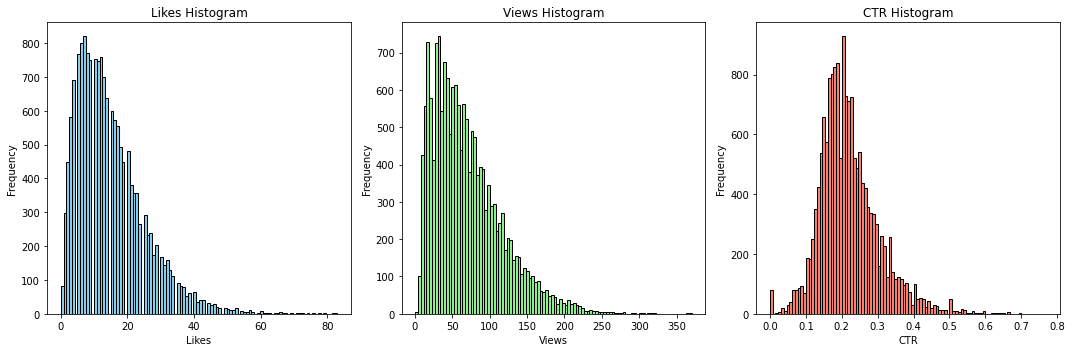

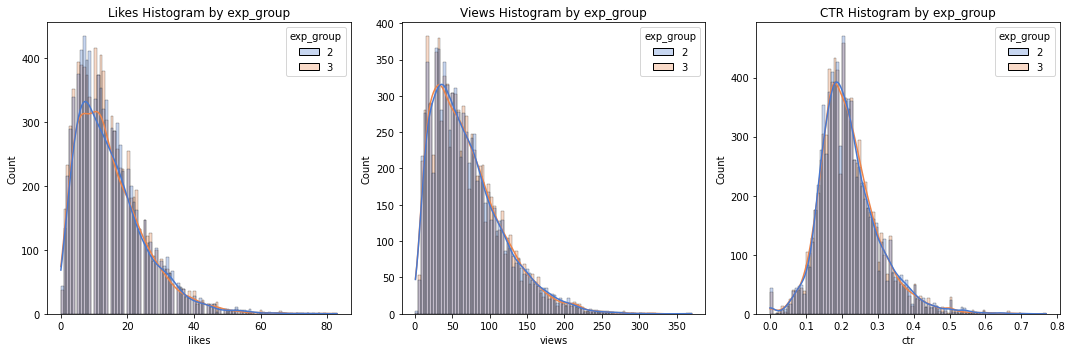

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

axes[0].hist(df['likes'], bins=100, color='skyblue', edgecolor='black')
axes[0].set_title('Likes Histogram')
axes[0].set_xlabel('Likes')
axes[0].set_ylabel('Frequency')

axes[1].hist(df['views'], bins=100, color='lightgreen', edgecolor='black')
axes[1].set_title('Views Histogram')
axes[1].set_xlabel('Views')
axes[1].set_ylabel('Frequency')

axes[2].hist(df['ctr'], bins=100, color='salmon', edgecolor='black')
axes[2].set_title('CTR Histogram')
axes[2].set_xlabel('CTR')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

sns.histplot(data=df, x='likes', bins=100, hue='exp_group', ax=axes[0], alpha=0.3, palette='muted', kde=True)
axes[0].set_title('Likes Histogram by exp_group')


sns.histplot(data=df, x='views', bins=100, hue='exp_group', ax=axes[1], alpha=0.3, palette='muted', kde=True)
axes[1].set_title('Views Histogram by exp_group')

sns.histplot(data=df, x='ctr', bins=100, hue='exp_group', ax=axes[2], alpha=0.3, palette='muted', kde=True)
axes[2].set_title('CTR Histogram by exp_group')

plt.tight_layout()
plt.show()

In [6]:
df.groupby('exp_group').size().reset_index(name='count')

,exp_group,count
0,2,8362
1,3,8425


**Summary** there is a lot of data (16787), no duplicates or omissions. The distribution of likes, views and CTR is close to normal, with a clear leftward bias for the first two cases. The sample size is about the same. There are no obstacles.

## A/A test

In [7]:
def calculate_pvalue(sample_size=500): 
    df_2_group = df[df['exp_group'] == 2]['ctr'].sample(n = sample_size, replace=False).tolist()
    df_3_group = df[df['exp_group'] == 3]['ctr'].sample(n = sample_size, replace=False).tolist()
    
    pvalue = ttest_ind(df_2_group, df_3_group)[1]

    return pvalue

In [8]:
%%time
pvalues_list = []
for _ in tqdm(range(10000), desc="Calculating p-values", unit="iteration"):
    pvalues_list.append(calculate_pvalue())
    
print('Number of p-values:', len(pvalues_list))

Calculating p-values: 100%|██████████| 10000/10000 [00:40<00:00, 247.02iteration/s]

Number of p-values: 10000
CPU times: user 39.6 s, sys: 220 ms, total: 39.8 s
Wall time: 40.5 s


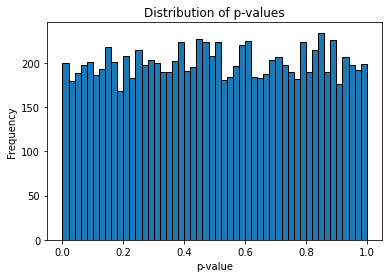

In [9]:
plt.hist(pvalues_list, bins=50, edgecolor='black')
plt.title('Distribution of p-values')
plt.xlabel('p-value')
plt.ylabel('Frequency')
plt.show() 

In [10]:
ALPHA = 0.05

significant_pvalues = np.sum(np.array(pvalues_list) <= ALPHA)
percentage_significant = (significant_pvalues / len(pvalues_list)) * 100

print(f"Percentage of p-values <= {ALPHA}: {percentage_significant:.2f}%")

Percentage of p-values <= 0.05: 4.74%


## A/A test conclusions 
According to the results of the A/A test, statistically significant differences between the two samples were found in <5% of cases. Given the uniform distribution of p-values, this is not surprising. **The A/A test can be recognized as successful.

# A/B test

In [11]:
%%time
query_to_select_data = """
        SELECT  user_id,
                exp_group,
                SUM(action = 'like') as likes,
                SUM(action = 'view') as views,
                likes/views as ctr
        FROM {db}.feed_actions
        WHERE toDate(time) between '2023-11-18' AND '2023-11-24'
                AND exp_group in (1,2)
        GROUP BY user_id, exp_group
"""

df = ph.read_clickhouse(query_to_select_data, connection=connection)
display(df.head(10).T)

,0,1,2,3,4,5,6,7,8,9
user_id,109963.0,26117.00000,138232.000000,26295.000000,18392.00000,131473.000000,23985.00000,24523.000000,32420.000000,24239.000000
exp_group,1.0,1.00000,1.000000,1.000000,1.00000,2.000000,2.00000,2.000000,2.000000,2.000000
likes,3.0,32.00000,18.000000,39.000000,7.00000,9.000000,7.00000,11.000000,13.000000,40.000000
views,15.0,141.00000,73.000000,141.000000,32.00000,108.000000,87.00000,101.000000,44.000000,90.000000
ctr,0.2,0.22695,0.246575,0.276596,0.21875,0.083333,0.08046,0.108911,0.295455,0.444444


CPU times: user 45.8 ms, sys: 10.2 ms, total: 56 ms
Wall time: 2.79 s


In [12]:
df_1 = df[df.exp_group == 1]
df_2 = df[df.exp_group == 2]


global_ctr_1 =  df_1.likes.sum()/df_1.views.sum()
global_ctr_2 = df_2.likes.sum()/df_2.views.sum()
print('global_ctr_1:', global_ctr_1, '\nglobal_ctr_2:', global_ctr_2)

mean_ctr_1 = df_1['ctr'].mean()
mean_ctr_2 = df_2['ctr'].mean()
print('\nmean_ctr_1:', mean_ctr_1, '\nmean_ctr_2:', mean_ctr_2)

global_ctr_1: 0.2096041628394293 
global_ctr_2: 0.20025051027061783

mean_ctr_1: 0.216773994120072 
mean_ctr_2: 0.2161016893237817


While there are no differences in average ctr, there are differences in global ctr.

In [13]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    return (user_likes + alpha + global_ctr)/(user_views + alpha)

df_1['smothed_ctr'] = df_1.apply(lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)
df_2['smothed_ctr'] = df_2.apply(lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

## T-test

In [14]:
print('T-test on normal data:',
                  stats.ttest_ind(df_1['ctr'],
                  df_2['ctr'],
                  equal_var=False)
     )

print('T-test on smoothed CTR:',
                 stats.ttest_ind(df_1['smothed_ctr'],
                 df_2['smothed_ctr'],
                 equal_var=False)
     )

T-test on normal data: Ttest_indResult(statistic=0.4051491913112757, pvalue=0.685373331140751)
T-test on smoothed CTR: Ttest_indResult(statistic=0.6645394515080011, pvalue=0.5063539822007146)


T-test does not show differences in the data. Neither does the mean value of ctr, but we note that the application of t-test on data with a large scatter (group 2) is generally not correct.

## Mann Whitneyu

In [15]:
%%time
print('Mann Whitneyu:', stats.mannwhitneyu(df_1.ctr, 
                   df_2.ctr)
     )

A_gt_B = 0
for _ in range(10000):
    A_gt_B+= df_1.ctr.sample().values[0] > df_2.ctr.sample().values[0]
    
print('В', A_gt_B/100, '% случаев A > B. Должно получиться около 50%')

Mann Whitneyu: MannwhitneyuResult(statistic=55189913.0, pvalue=4.632205841806026e-45)
В 55.6 % случаев A > B. Должно получиться около 50%
CPU times: user 6.04 s, sys: 3.73 ms, total: 6.04 s
Wall time: 6.12 s


The Mann-Whitney test shows differences between samples! Let's turn to more advanced methods.

## Poisson's bootstrap

In [16]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=10000):
    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

In [17]:
%%time
ctr1, ctr2 = bootstrap(df_1.likes.to_numpy(), df_1.views.to_numpy(), df_2.likes.to_numpy(), df_2.views.to_numpy())

CPU times: user 13.5 s, sys: 2.39 s, total: 15.9 s
Wall time: 16 s


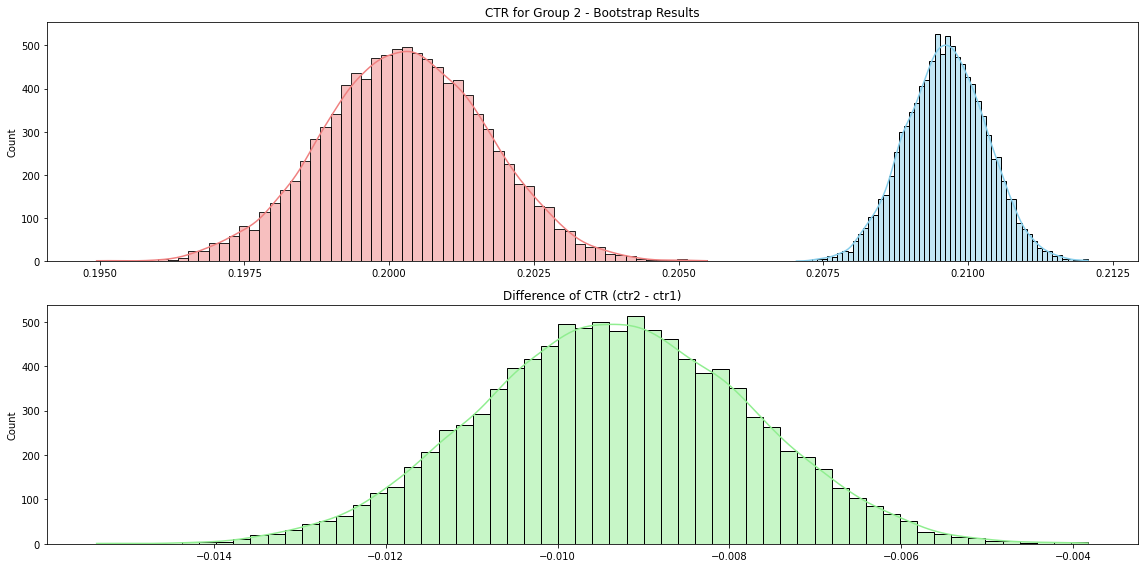

In [18]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(16, 8))

sns.histplot(ctr1, kde=True, ax=ax0, color='skyblue')
ax0.set_title('CTR for Group 1 - Bootstrap Results')

sns.histplot(ctr2, kde=True, ax=ax0, color='lightcoral')
ax0.set_title('CTR for Group 2 - Bootstrap Results')

sns.histplot(ctr2 - ctr1, kde=True, ax=ax1, color='lightgreen')
ax1.set_title('Difference of CTR (ctr2 - ctr1)')

plt.tight_layout()
plt.show()

## Bucket conversion

In [19]:
def add_bucket_ctr(df):
    help_df = pd.DataFrame()
    for group_name, group in df.groupby('bucket'):
        bucket_ctr_value = group['likes'].sum() / group['views'].sum()
        help_df = pd.concat([help_df, pd.DataFrame({'bucket': [group_name], 'bucket_ctr': [bucket_ctr_value]})])

    df = pd.merge(df, help_df, on='bucket', how='left')
    return df

def split_dataset_to_buckets(dataset, number_of_buckets):
    dataset = dataset.sample(frac=1).reset_index(drop=True)

    rows_per_bucket = len(dataset) // number_of_buckets
   # print(rows_per_bucket)
    dataset['bucket'] = np.nan

    for bucket in range(number_of_buckets):
        start_index = bucket * rows_per_bucket
        if bucket == number_of_buckets - 1:
            end_index = len(dataset)
        else:
            end_index = start_index + rows_per_bucket
        dataset.loc[start_index:end_index, 'bucket'] = bucket

    remaining_rows = len(dataset) % number_of_buckets
   # print(remaining_rows)
    if remaining_rows > 0:
        dataset.tail(remaining_rows)['bucket'] = np.arange(remaining_rows)

    return add_bucket_ctr(dataset).dropna()

def plot_bucket_distribution(dataset):
    bucket_counts = dataset['bucket'].value_counts().sort_index()

    plt.bar(bucket_counts.index, bucket_counts.values, color='skyblue')
    plt.xlabel('Bucket')
    plt.ylabel('Number of Rows')
    plt.title('Distribution of Rows Across Buckets')
    plt.show()


,0,1,2,3,4
user_id,132145.000000,111304.000000,29387.000000,129065.000000,139136.000000
exp_group,1.000000,1.000000,1.000000,1.000000,1.000000
likes,21.000000,15.000000,14.000000,16.000000,11.000000
views,77.000000,40.000000,70.000000,110.000000,46.000000
ctr,0.272727,0.375000,0.200000,0.145455,0.239130
smothed_ctr,0.319629,0.449102,0.256128,0.184431,0.317835
bucket,0.000000,0.000000,0.000000,0.000000,0.000000
bucket_ctr,0.211914,0.211914,0.211914,0.211914,0.211914


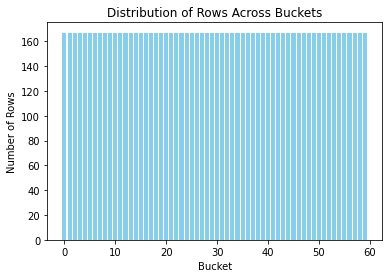

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10020 entries, 0 to 10019
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   user_id      10020 non-null  uint32 
 1   exp_group    10020 non-null  int8   
 2   likes        10020 non-null  uint64 
 3   views        10020 non-null  uint64 
 4   ctr          10020 non-null  float64
 5   smothed_ctr  10020 non-null  float64
 6   bucket       10020 non-null  float64
 7   bucket_ctr   10020 non-null  float64
dtypes: float64(4), int8(1), uint32(1), uint64(2)
memory usage: 518.7 KB


None

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59.]


In [20]:
number_of_buckets = 60
df_1_bucket = split_dataset_to_buckets(df_1, number_of_buckets)
df_2_bucket = split_dataset_to_buckets(df_2, number_of_buckets)

display(df_1_bucket.head(5).T)
plot_bucket_distribution(df_1_bucket)

display(df_1_bucket.info())
print(df_1_bucket['bucket'].unique())

In [21]:
%%time
print('Mann Whitneye:', stats.mannwhitneyu(df_1_bucket['bucket_ctr'], 
                       df_2_bucket['bucket_ctr'], 
                       alternative = 'two-sided')
     )


print('T-test:', stats.ttest_ind(df_1_bucket['bucket_ctr'], 
                   df_2_bucket['bucket_ctr'], 
                   equal_var = False)
     )

Mann Whitneye: MannwhitneyuResult(statistic=76717963.0, pvalue=0.0)
T-test: Ttest_indResult(statistic=78.97285588842443, pvalue=0.0)
CPU times: user 26.4 ms, sys: 2.99 ms, total: 29.4 ms
Wall time: 29.4 ms


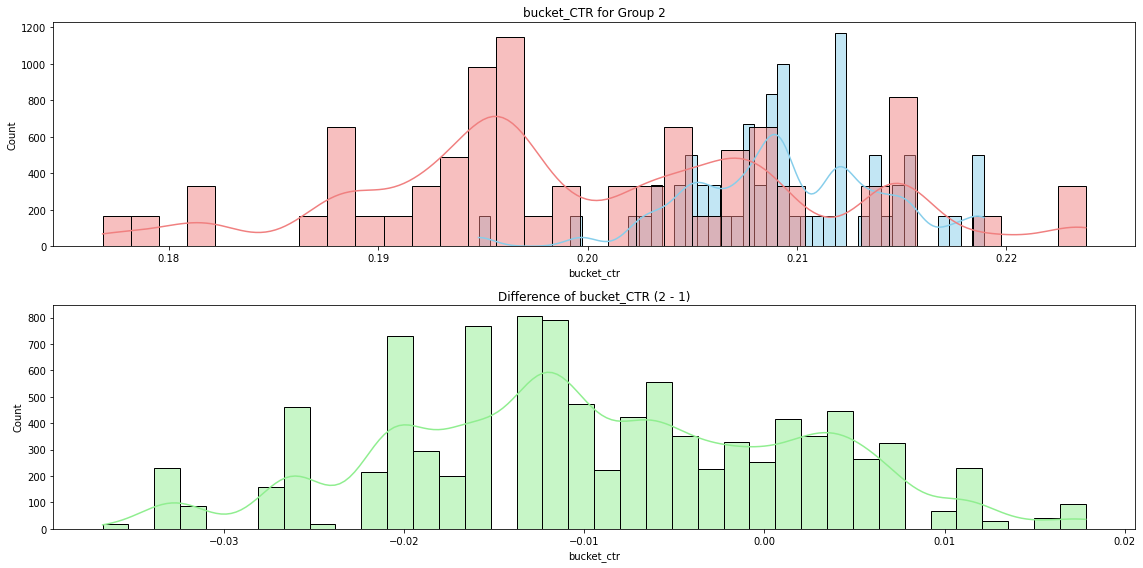

In [22]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(16, 8))

sns.histplot(df_1_bucket['bucket_ctr'], kde=True, ax=ax0, color='skyblue')
ax0.set_title('bucket_CTR for Group 1')

sns.histplot(df_2_bucket['bucket_ctr'], kde=True, ax=ax0, color='lightcoral')
ax0.set_title('bucket_CTR for Group 2')

sns.histplot(df_2_bucket['bucket_ctr'] - df_1_bucket['bucket_ctr'], kde=True, ax=ax1, color='lightgreen')
ax1.set_title('Difference of bucket_CTR (2 - 1)')

plt.tight_layout()
plt.show()

## A/B Yandex test

In [23]:
%%time
query_to_select_data = """
        SELECT  user_id,
                exp_group,
                SUM(action = 'like') as likes,
                SUM(action = 'view') as views,
                likes/views as ctr
        FROM {db}.feed_actions
        WHERE toDate(time) between '2023-11-18' AND '2023-11-24'
                AND exp_group in (0, 1, 2, 3)
        GROUP BY user_id, exp_group
"""

df = ph.read_clickhouse(query_to_select_data, connection=connection)
display(df.head(10).T)

df_0 = df[df['exp_group'] == 0]
df_1 = df[df['exp_group'] == 1]
df_2 = df[df['exp_group'] == 2]
df_3 = df[df['exp_group'] == 3]

,0,1,2,3,4,5,6,7,8,9
user_id,18392.00000,115383.000000,123580.000000,131473.000000,32420.000000,24239.000000,30319.000000,27443.000000,118359.000000,27131.000000
exp_group,1.00000,3.000000,3.000000,2.000000,2.000000,2.000000,0.000000,1.000000,3.000000,1.000000
likes,7.00000,12.000000,2.000000,9.000000,13.000000,40.000000,25.000000,22.000000,7.000000,12.000000
views,32.00000,44.000000,11.000000,108.000000,44.000000,90.000000,114.000000,109.000000,38.000000,89.000000
ctr,0.21875,0.272727,0.181818,0.083333,0.295455,0.444444,0.219298,0.201835,0.184211,0.134831


CPU times: user 58.5 ms, sys: 9.16 ms, total: 67.6 ms
Wall time: 2.26 s


In [24]:
def calculate_linearized_likes(df, CTR_control):
    df['lin_likes'] = df['likes'] - CTR_control*df['views']
    return df

CTR_control_0 = df_0['likes'].sum()/df_0['views'].sum()
df_0 = calculate_linearized_likes(df_0, CTR_control_0)
display(df_0.head(5).T) 

,6,10,23,24,26
user_id,30319.000000,7626.000000,12217.000000,3450.000000,109621.000000
exp_group,0.000000,0.000000,0.000000,0.000000,0.000000
likes,25.000000,14.000000,12.000000,10.000000,25.000000
views,114.000000,39.000000,52.000000,42.000000,166.000000
ctr,0.219298,0.358974,0.230769,0.238095,0.150602
lin_likes,1.078469,5.816318,1.088424,1.186804,-9.833107


In [25]:
CTR_control_1 = df_1['likes'].sum()/df_1['views'].sum()

df_1 = calculate_linearized_likes(df_1, CTR_control_1)
df_2 = calculate_linearized_likes(df_2, CTR_control_1)
df_3 = calculate_linearized_likes(df_3, CTR_control_0)

In [26]:
def make_p_test(df1, df2, info_str):
    print(f'for {info_str}')
    print('T-test on ctr:',
                  stats.ttest_ind(df1['ctr'],
                  df2['ctr'],
                  equal_var=False)
     )
    
    print('T-test on linearized_likes:',
                  stats.ttest_ind(df1['lin_likes'],
                  df2['lin_likes'],
                  equal_var=False)
     )
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    
    union_df = pd.concat([df1, df2])

    sns.histplot(data=union_df, x='ctr', bins=100, hue='exp_group', ax=axes[0], alpha=0.3, palette='muted', kde=True)
    axes[0].set_title('CTR by exp_group')

    sns.histplot(data=union_df, x='lin_likes', bins=100, hue='exp_group', ax=axes[1], alpha=0.3, palette='muted', kde=True)
    axes[1].set_title('linearized likes by exp_group')

    plt.tight_layout()
    plt.show() 

for 0 vs 3
T-test on ctr: Ttest_indResult(statistic=-13.935320516755823, pvalue=6.216047483057877e-44)
T-test on linearized_likes: Ttest_indResult(statistic=-16.18623003293285, pvalue=1.4918137745324434e-58)


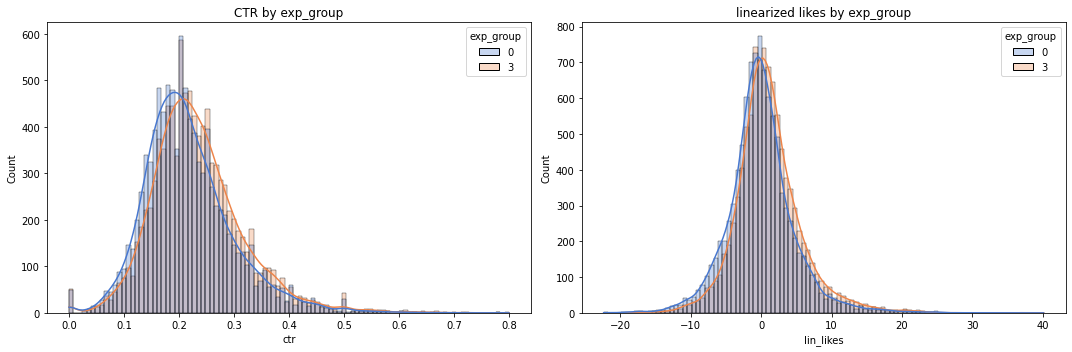

In [27]:
make_p_test(df_0, df_3, '0 vs 3')

for 1 vs 2
T-test on ctr: Ttest_indResult(statistic=0.40514919131127564, pvalue=0.685373331140751)
T-test on linearized_likes: Ttest_indResult(statistic=5.936377101934478, pvalue=2.9805064038668383e-09)


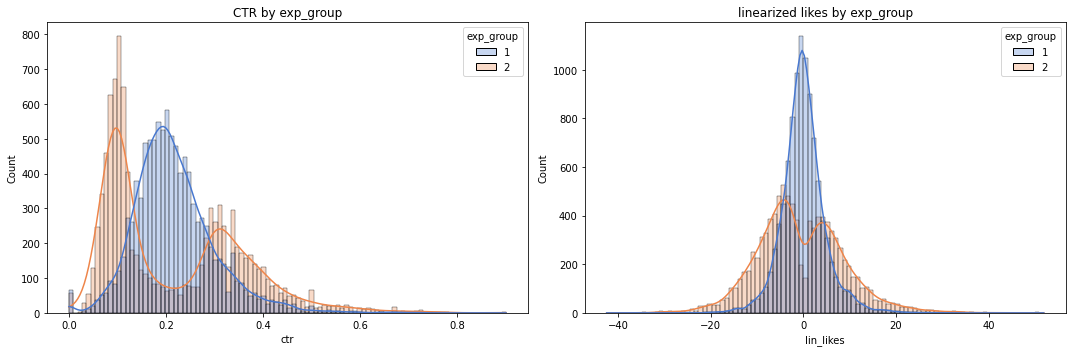

In [28]:
make_p_test(df_1, df_2, '1 vs 2')

In both cases, the method resulted in smoothing distributions and increasing the difference between samples (decreasing pvalue).  
In cases 1 and 2, it even led to an increase in the t-test result - the difference that was visible by bootstrap and not visible by t-test for ctr turned out to be visible by t-test for linearized likes.  
**Conclusion - the method works**

## Conclusion
- **Groups do differ**, as evidenced by bootstrap and the Manny Vuitney test.  
- The t-test and the bucket methods did not show any difference, **but** their application in this case is inappropriate due to the **explicit bimodality of the CTR distribution** for users in group 2 (test). 

The fact that the sample for the test group has become bimodal (where one mode has a mean lower than the control and the other higher) is **very dangerous**. Apparently, some (about half) of the users approved of the new feature, and some vice versa. This may be due to technical problems (for example, computer and iPhone users have problems when viewing the innovation, while for Android users everything is fine). So and with the peculiarities of the algorithm, for example, gizinam new innovation liked, and men do not.  
In any case, **the innovation should not be introduced *now*, because the majority of users do not approve of it, it is necessary to investigate the reasons for this!

## Additional analysis
According to the results of additional analysis, we can see that the more active audience (by the number of views) did not accept the new innovation!  
This can be seen in the distribution of CTR for the control and test groups. While in the control group CTR practically does not depend on the number of views, in the case of the test group there is a negative correlation.

In [30]:
%%time
query_to_select_all_data = """
        SELECT  user_id
            , MAX(gender) as gender
            , MAX(age) as age
            , MAX(country) as country
            , MAX(os) AS os
            , MAX(source) AS source
            , SUM(action = 'like') as likes
            , SUM(action = 'view') as views
            , likes/views as ctr
        FROM {db}.feed_actions
        WHERE toDate(time) between '2023-11-18' AND '2023-11-24'
                AND exp_group in (2)
        GROUP BY user_id
"""

analysis_df = ph.read_clickhouse(query_to_select_all_data, connection=connection)
display(analysis_df.head(10).T)

,0,1,2,3,4,5,6,7,8,9
user_id,129127,129711,114145,133700,22116,21676,29717,128337,128483,120154
gender,1,0,1,0,1,1,1,0,0,0
age,24,21,23,62,17,19,40,19,17,15
country,Russia,Ukraine,Russia,Russia,Russia,Russia,Russia,Russia,Belarus,Russia
os,Android,Android,Android,Android,Android,Android,Android,Android,Android,iOS
source,organic,organic,organic,organic,ads,ads,ads,organic,organic,organic
likes,16,10,22,7,8,2,6,3,48,10
views,117,43,110,34,80,27,33,64,120,23
ctr,0.136752,0.232558,0.2,0.205882,0.1,0.074074,0.181818,0.046875,0.4,0.434783


CPU times: user 54.9 ms, sys: 4.38 ms, total: 59.3 ms
Wall time: 1.62 s


In [31]:
print(analysis_df.columns)

Index(['user_id', 'gender', 'age', 'country', 'os', 'source', 'likes', 'views',
       'ctr'],
      dtype='object')


In [32]:
def analyze_mean_ctr(df, group_column):
    grouped_df = df.groupby(group_column)['ctr'].agg(['mean', 'size']).reset_index()
    grouped_df = grouped_df.rename(columns={'mean': 'ctr', 'size': 'group_size'})
    print(f"Mean CTR by {group_column}:")
    display(grouped_df.sort_values(by='ctr'))

analyze_mean_ctr(analysis_df, 'gender')
analyze_mean_ctr(analysis_df, 'os')
analyze_mean_ctr(analysis_df, 'source')
analyze_mean_ctr(analysis_df, 'country')

Mean CTR by gender:


,gender,ctr,group_size
1,1,0.215752,5495
0,0,0.216540,4382


Mean CTR by os:


,os,ctr,group_size
1,iOS,0.214400,3512
0,Android,0.217041,6365


Mean CTR by source:


,source,ctr,group_size
1,organic,0.215558,5235
0,ads,0.216715,4642


Mean CTR by country:


,country,ctr,group_size
8,Switzerland,0.166655,10
1,Belarus,0.198887,200
9,Turkey,0.208924,84
4,Finland,0.209893,106
5,Kazakhstan,0.212948,199
10,Ukraine,0.215508,481
6,Latvia,0.216383,8
7,Russia,0.216424,8660
3,Estonia,0.219363,6
0,Azerbaijan,0.234741,111


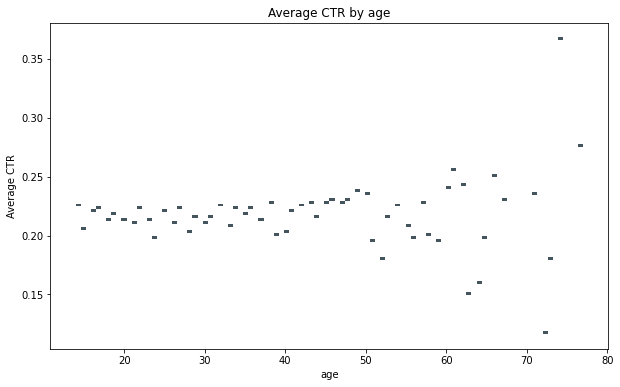

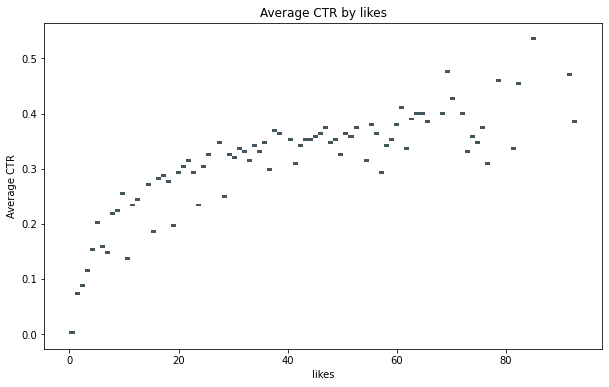

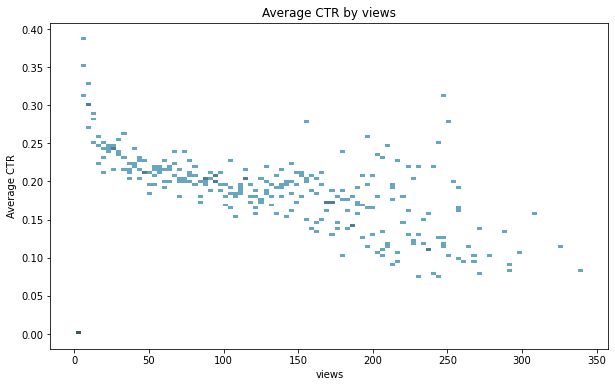

In [33]:
def plot_avg_ctr_by_age(df, quant_column):
    grouped_df = df.groupby(quant_column)['ctr'].mean().reset_index()

    # Plot histogram
    plt.figure(figsize=(10, 6))
    #plt.bar(grouped_df[quant_column], grouped_df['ctr'], color='skyblue')
    sns.histplot(data=grouped_df, x=quant_column, y='ctr', bins=100, color='skyblue', kde=True)
    
    plt.xlabel(f'{quant_column}')
    plt.ylabel('Average CTR')
    plt.title(f'Average CTR by {quant_column}')
    plt.show()

plot_avg_ctr_by_age(analysis_df, 'age')
plot_avg_ctr_by_age(analysis_df, 'likes')
plot_avg_ctr_by_age(analysis_df, 'views')

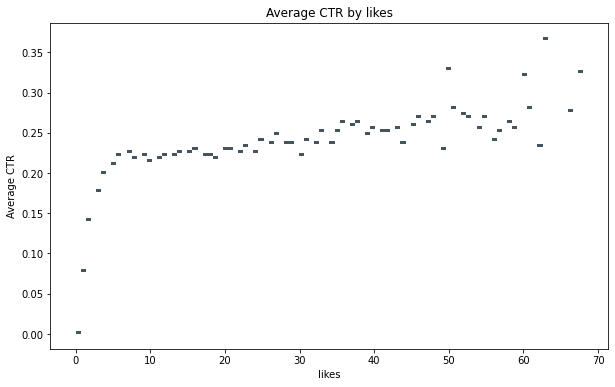

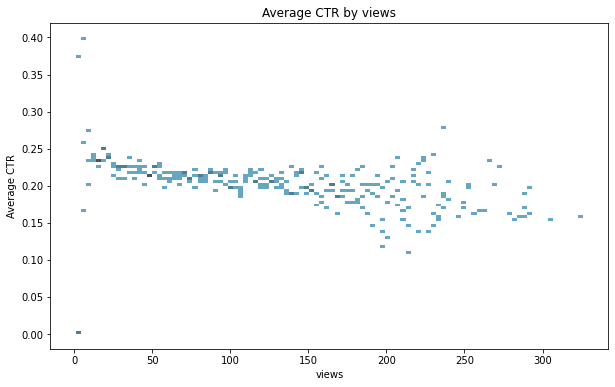

In [34]:
query_to_select_all_data_control = """
        SELECT  user_id
            , MAX(gender) as gender
            , MAX(age) as age
            , MAX(country) as country
            , MAX(os) AS os
            , MAX(source) AS source
            , SUM(action = 'like') as likes
            , SUM(action = 'view') as views
            , likes/views as ctr
        FROM {db}.feed_actions
        WHERE toDate(time) between '2023-11-18' AND '2023-11-24'
                AND exp_group in (1)
        GROUP BY user_id
"""

analysis_df_control = ph.read_clickhouse(query_to_select_all_data_control, connection=connection)
plot_avg_ctr_by_age(analysis_df_control, 'likes')
plot_avg_ctr_by_age(analysis_df_control, 'views')